# 2D burgers equation, direct problem
---

Consider the 2d burgers equation
$$
\begin{aligned}
&u_t + uu_x + vu_y = \frac{1}{R}(u_{xx} + u_{yy}),  \\
&v_t + uv_x + vv_y = \frac{1}{R}(v_{xx} + v_{yy}), 
\end{aligned}
$$
in the domain $(x, y, t) \in [0, 0.5]^3$, with $R = 1$. (which doesn't matter since $u_{xx}=u_{yy} = 0$).

Analytic solution:
$$
u(x,y,t) = \frac{x+y-2xt}{1-2t^2}, \ v(x, y, t) = \frac{x-y-2yt}{1-2t^2}.
$$

In [1]:
NAME = "4_2d_burgers"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

layers = [3, 128, 128, 128, 128, 128, 2] # (x, y, t) -> (u, v)
c0 = 1.0
w0 = 10.0
lambda_0 = 1e-10
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0)

@jax.jit
def scalar_u_model(params, x, y, t):
	x_ = jnp.hstack([x, y, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0][:, 0:1]) + params[-1][1][0])

@jax.jit
def scalar_v_model(params, x, y, t):
	x_ = jnp.hstack([x, y, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0][:, 1:2]) + params[-1][1][1])

u_model = jax.jit(jax.vmap(scalar_u_model, in_axes = (None, 0, 0, 0)))
v_model = jax.jit(jax.vmap(scalar_v_model, in_axes = (None, 0, 0, 0)))

In [4]:
R = 1.0
domain = [0, 0.5]
T_max = 0.5

u_fn = lambda x, y, t: (x+y-2*x*t)/(1-2*t**2)
v_fn = lambda x, y, t: (x-y-2*y*t)/(1-2*t**2)

In [5]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def scalar_du_dx(params, x, y, t):
    return jnp.sum(jax.grad(scalar_u_model, 1)(params, x, y, t))

@jax.jit
def scalar_du_dy(params, x, y, t):
    return jnp.sum(jax.grad(scalar_u_model, 2)(params, x, y, t))

@jax.jit
def scalar_du_dt(params, x, y, t):
    return jnp.sum(jax.grad(scalar_u_model, 3)(params, x, y, t))

du_dx = jax.jit(jax.vmap(scalar_du_dx, in_axes = (None, 0, 0, 0)))
du_dy = jax.jit(jax.vmap(scalar_du_dy, in_axes = (None, 0, 0, 0)))
du_dt = jax.jit(jax.vmap(scalar_du_dt, in_axes = (None, 0, 0, 0)))

@jax.jit
def du_dxx(params, x, y, t):
    return jax.grad(scalar_du_dx, 1)(params, x, y, t)

@jax.jit
def du_dyy(params, x, y, t):
    return jax.grad(scalar_du_dy, 2)(params, x, y, t)

@jax.jit
def du_dtt(params, x, y, t):
    return jax.grad(scalar_du_dt, 3)(params, x, y, t)

@jax.jit
def scalar_dv_dx(params, x, y, t):
    return jnp.sum(jax.grad(scalar_v_model, 1)(params, x, y, t))

@jax.jit
def scalar_dv_dy(params, x, y, t):
    return jnp.sum(jax.grad(scalar_v_model, 2)(params, x, y, t))

@jax.jit
def scalar_dv_dt(params, x, y, t):
    return jnp.sum(jax.grad(scalar_v_model, 3)(params, x, y, t))

dv_dx = jax.jit(jax.vmap(scalar_dv_dx, in_axes = (None, 0, 0, 0)))
dv_dy = jax.jit(jax.vmap(scalar_dv_dy, in_axes = (None, 0, 0, 0)))
dv_dt = jax.jit(jax.vmap(scalar_dv_dt, in_axes = (None, 0, 0, 0)))

@jax.jit
def dv_dxx(params, x, y, t):
    return jax.grad(scalar_dv_dx, 1)(params, x, y, t)

@jax.jit
def dv_dyy(params, x, y, t):
    return jax.grad(scalar_dv_dy, 2)(params, x, y, t)

@jax.jit
def dv_dtt(params, x, y, t):
    return jax.grad(scalar_dv_dt, 3)(params, x, y, t)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	u_ = u_model(direct_params, collocation.x, collocation.y, collocation.t)
	v_ = v_model(direct_params, collocation.x, collocation.y, collocation.t)
	du_dt_ = du_dt(direct_params, collocation.x, collocation.y, collocation.t)
	du_dx_ = du_dx(direct_params, collocation.x, collocation.y, collocation.t)
	du_dy_ = du_dy(direct_params, collocation.x, collocation.y, collocation.t)
	dv_dt_ = dv_dt(direct_params, collocation.x, collocation.y, collocation.t)
	dv_dx_ = dv_dx(direct_params, collocation.x, collocation.y, collocation.t)
	dv_dy_ = dv_dy(direct_params, collocation.x, collocation.y, collocation.t)    
	du_dxx_ = du_dxx(direct_params, collocation.x, collocation.y, collocation.t)
	du_dyy_ = du_dyy(direct_params, collocation.x, collocation.y, collocation.t)
	dv_dxx_ = dv_dxx(direct_params, collocation.x, collocation.y, collocation.t)
	dv_dyy_ = dv_dyy(direct_params, collocation.x, collocation.y, collocation.t)
	
	u_pred = u_model(direct_params, dirichlet.x, dirichlet.y, dirichlet.t).reshape((-1, 1))
	v_pred = v_model(direct_params, dirichlet.x, dirichlet.y, dirichlet.t).reshape((-1, 1))
	
	loss_c1 = mse(du_dt_ + u_*du_dx_ + v_*du_dy_, 1/R*(du_dxx_ + du_dyy_))
	loss_c2 = mse(dv_dt_ + u_*dv_dx_ + v_*dv_dy_, 1/R*(dv_dxx_ + dv_dyy_))
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = mse(u_pred, dirichlet.u)
	loss_d2 = mse(v_pred, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	return loss_c, loss_d

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d, loss_c, loss_d

In [6]:
key = random.PRNGKey(1)

# ic
key, *subkeys = random.split(key, 4)
n_i = 10000
x_i = random.uniform(subkeys[0], (n_i, 1), np.float32, minval = domain[0], maxval = domain[1])
y_i = random.uniform(subkeys[1], (n_i, 1), np.float32, minval = domain[0], maxval = domain[1])
t_i = jnp.zeros_like(x_i)
u_i = u_fn(x_i, y_i, t_i)
v_i = v_fn(x_i, y_i, t_i)

# bc
key, *subkeys = random.split(key, 4)
n_b = 10000
x_b = random.uniform(subkeys[0], (n_b, 1), np.float32, minval = domain[0], maxval = domain[1])
y_b = random.uniform(subkeys[1], (n_b, 1), np.float32, minval = domain[0], maxval = domain[1])
x_b = jnp.vstack([x_b, jnp.ones((n_b, 1))*domain[1], x_b, jnp.ones((n_b, 1))*domain[0]])
y_b = jnp.vstack([jnp.ones((n_b, 1))*domain[0], y_b, jnp.ones((n_b, 1))*domain[1], y_b])
t_b = random.uniform(subkeys[2], (n_b*4, 1), np.float32, minval = 0, maxval = T_max)
u_b = u_fn(x_b, y_b, t_b)
v_b = v_fn(x_b, y_b, t_b)

# c
n_c = 100
x_c = jnp.linspace(*domain, n_c)
y_c = jnp.linspace(*domain, n_c)
t_c = jnp.linspace(0, T_max, n_c)
txy_c = tensor_grid([t_c, x_c, y_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "y", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "y", "t"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [jnp.vstack([x_i, x_b]), jnp.vstack([y_i, y_b]),
															jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b]), jnp.vstack([v_i, v_b])]))
collocation = dataset_Collocation(*map(lambda x: jnp.array(x), [jnp.vstack([txy_c[:, 1:2], dirichlet.x]),
																jnp.vstack([txy_c[:, 2:3], dirichlet.y]), 
																jnp.vstack([txy_c[:, 0:1], dirichlet.t])]))

class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [7]:
lr = 1e-4
start_iteration = 0
iterations = 50000
print_every = 1000
save_every = 50000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1.0
w_d = 100.0

key, *subkeys = random.split(key, 3)

Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size_dirichlet)
Collocation = Batch_Generator(subkeys[1], collocation, batch_size_collocation)
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 00:22:23, Iteration: 1000, Train Loss: 1.2255e-01, c: 9.5199e-02, d: 2.7347e-04
2020/07/31, 00:23:11, Iteration: 2000, Train Loss: 6.8949e-02, c: 5.8802e-02, d: 1.0147e-04
2020/07/31, 00:24:00, Iteration: 3000, Train Loss: 3.4103e-02, c: 2.8692e-02, d: 5.4118e-05
2020/07/31, 00:24:50, Iteration: 4000, Train Loss: 9.1988e-02, c: 7.8121e-02, d: 1.3866e-04
2020/07/31, 00:25:38, Iteration: 5000, Train Loss: 2.0955e-02, c: 1.8025e-02, d: 2.9294e-05
2020/07/31, 00:26:27, Iteration: 6000, Train Loss: 1.4001e-02, c: 1.2276e-02, d: 1.7247e-05
2020/07/31, 00:27:15, Iteration: 7000, Train Loss: 1.3794e-02, c: 1.2292e-02, d: 1.5027e-05
2020/07/31, 00:28:04, Iteration: 8000, Train Loss: 1.5509e-02, c: 1.3072e-02, d: 2.4371e-05
2020/07/31, 00:28:52, Iteration: 9000, Train Loss: 1.2967e-02, c: 1.1537e-02, d: 1.4306e-05
2020/07/31, 00:29:41, Iteration: 10000, Train Loss: 1.8974e-02, c: 1.5135e-02, d: 3.8385e-05
2020/07/31, 00:30:29, Iteration: 11000, Train Loss: 8.5554e-03, c: 7.4035e-03, 

In [ ]:
# start_iteration = 50000
# iterations = 100000
# print_every = 1000
# save_every = 50000

# w_c = 1.0
# w_d = 100.0

# for iteration in range(start_iteration+1, start_iteration+iterations+1):
# 	batch = {
# 		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
# 		"collocation": dataset_Collocation(*next(Collocation)),
# 		"weights": {"c": w_c, "d": w_d}
# 	}
# 	opt_state = step(iteration, opt_state, batch)
# 	if (iteration-start_iteration) % print_every == 0:
# 		names = ["Loss", "c", "d"]
# 		params_ = get_params(opt_state)
# 		losses = evaluate(params_, batch)
# 		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
# 			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
# 	if (iteration-start_iteration) % save_every == 0:
# 		params_ = np.asarray(get_params(opt_state), dtype = object)
# 		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
# 		if not os.path.exists(os.path.dirname(save_path)):
# 			os.makedirs(os.path.dirname(save_path))
# 		np.save(save_path, params_)

In [46]:
n_test = 99
x_test_ = jnp.linspace(*domain, n_test)
y_test_ = jnp.linspace(*domain, n_test)
t_test_ = jnp.linspace(0, T_max, n_test)
txy_test = tensor_grid([t_test_, x_test_, y_test_])

x_test, y_test, t_test = txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]
param_ = get_params(opt_state)
u_pred = u_model(param_, x_test, y_test, t_test).reshape((-1, 1))
v_pred = v_model(param_, x_test, y_test, t_test).reshape((-1, 1))
u_true = u_fn(x_test, y_test, t_test)
v_true = v_fn(x_test, y_test, t_test)

u_error = mse(u_true, u_pred)
v_error = mse(v_true, v_pred)
print(u_error, v_error)

3.5486007e-08 1.911993e-07


In [40]:
import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

def plot_(t_index):
	txy_test = tensor_grid([t_test_[t_index], x_test_, y_test_])
	u_pred = u_model(get_params(opt_state), txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_test, n_test))
	u_true = u_fn(txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_test, n_test))
	
	v_pred = v_model(get_params(opt_state), txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_test, n_test))
	v_true = v_fn(txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_test, n_test))

	cmap = cool
	norm = Normalize(vmin=-0.5, vmax=0.5)

	X, Y = np.meshgrid(x_test_, y_test_)
	fig, ax = plt.subplots(2, 3, figsize = (15, 10))
	fig.subplots_adjust(right = 1.0)

	im0 = ax[0][0].contourf(X, Y, u_true, cmap = cmap, norm = norm, levels = 1000)
	ax[0][0].set_title("u_true")
	divider = make_axes_locatable(ax[0][0])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
	im1 = ax[0][1].contourf(X, Y, u_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[0][1].set_title("u_pred")
	ax[0][1].set_xlabel("")
	divider = make_axes_locatable(ax[0][1])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
	im2 = ax[0][2].contourf(X, Y, u_true - u_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[0][2].set_title("t = {:.4e}, MSE: {:.4e}".format(t_test_[t_index], np.mean(np.square(u_true - u_pred))))
	divider = make_axes_locatable(ax[0][2])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')
	
	im3 = ax[1][0].contourf(X, Y, v_true, cmap = cmap, norm = norm, levels = 1000)
	ax[1][0].set_title("v_true")
	divider = make_axes_locatable(ax[1][0])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
	im4 = ax[1][1].contourf(X, Y, v_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[1][1].set_title("v_pred")
	ax[1][1].set_xlabel("")
	divider = make_axes_locatable(ax[1][1])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
	im5 = ax[1][2].contourf(X, Y, v_true - v_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[1][2].set_title("t = {:.4e}, MSE: {:.4e}".format(t_test_[t_index], np.mean(np.square(v_true - v_pred))))
	divider = make_axes_locatable(ax[1][2])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	plt.show()

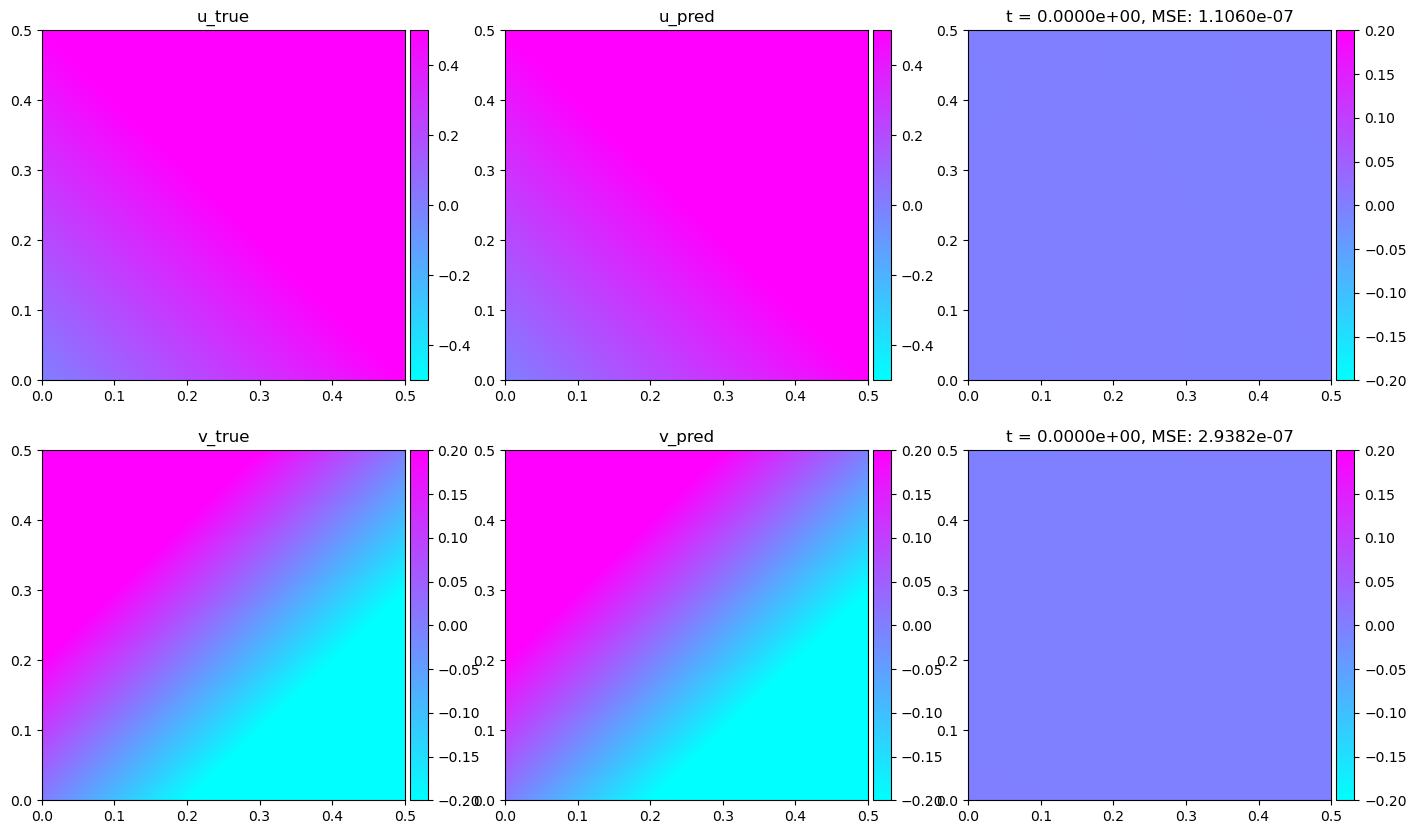

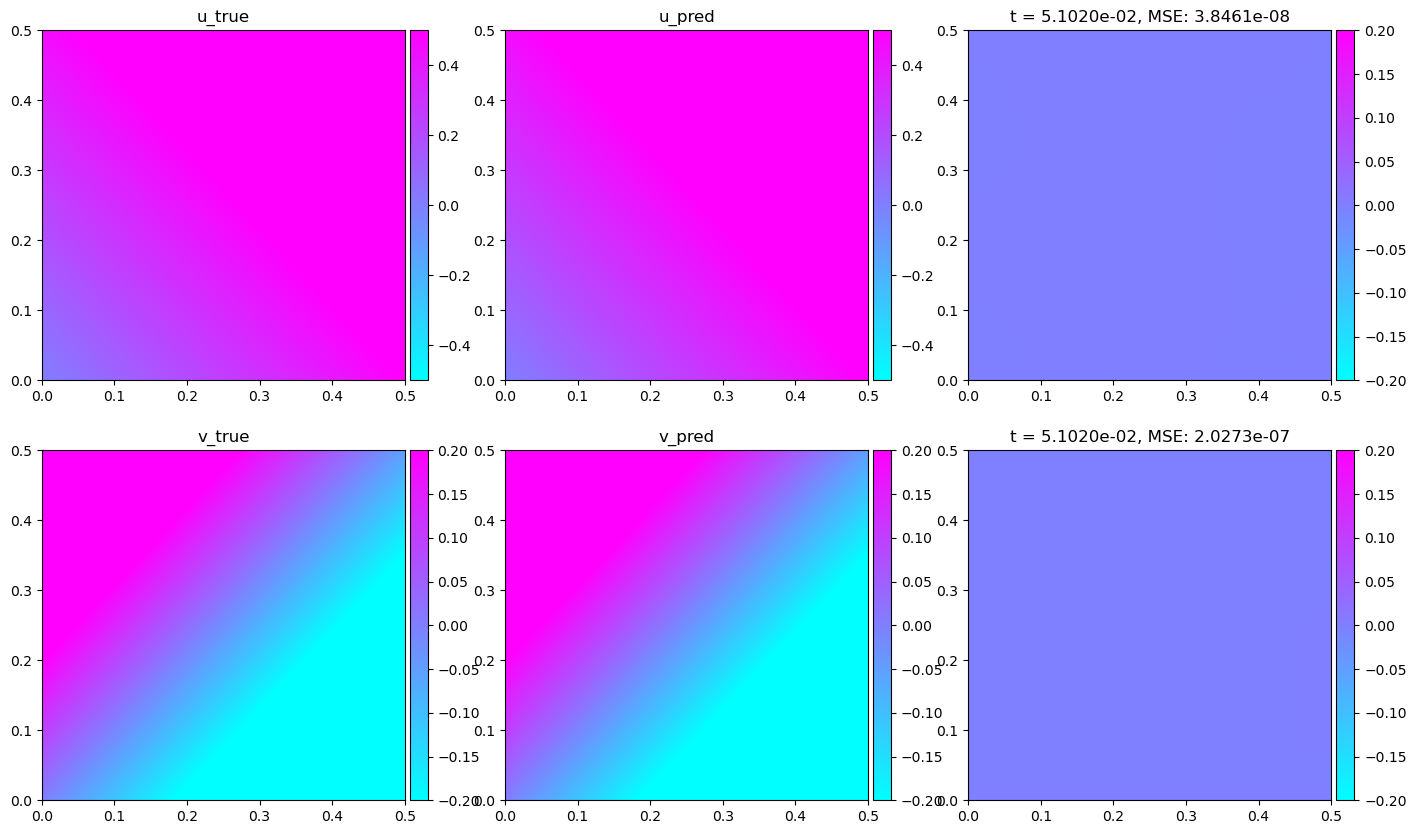

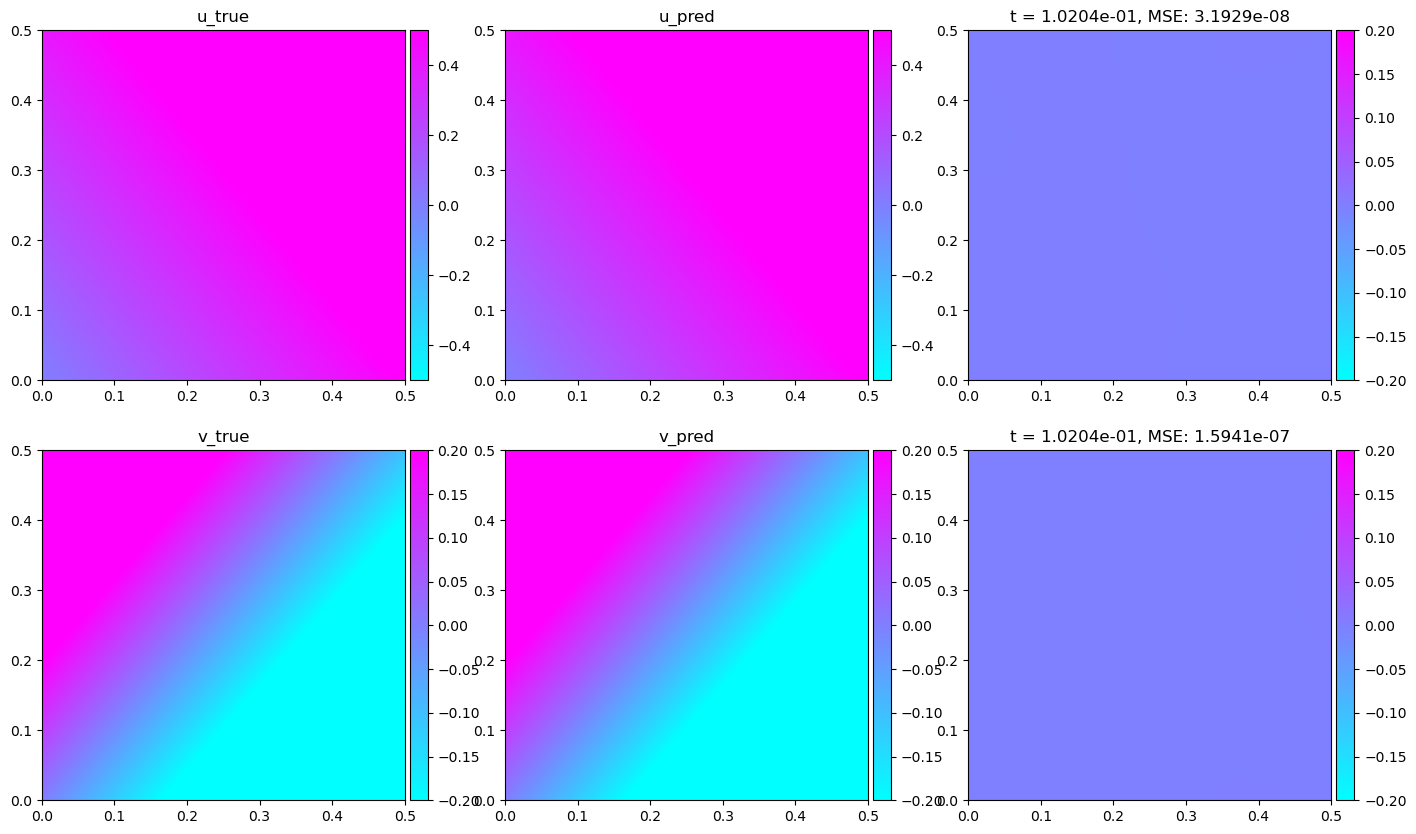

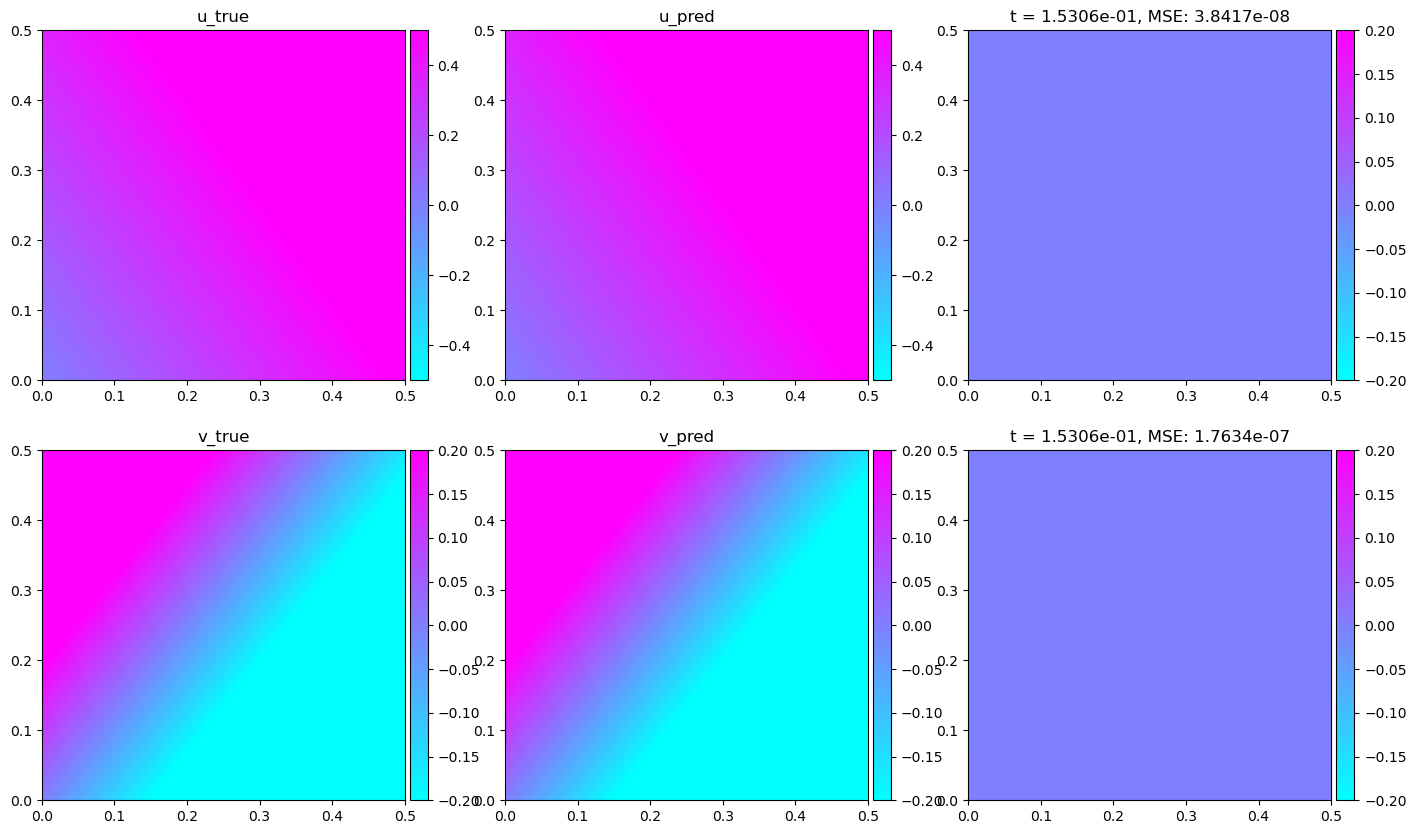

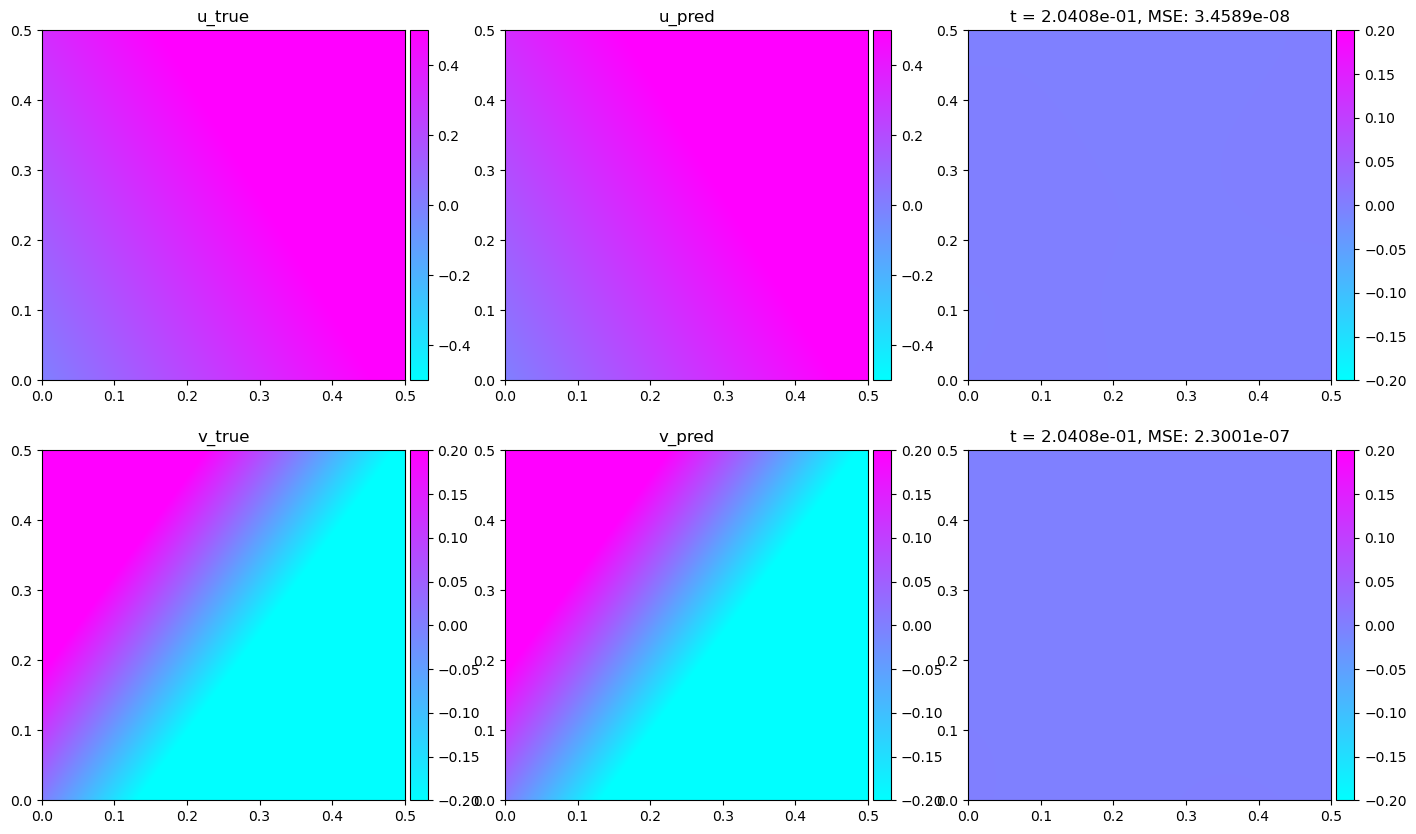

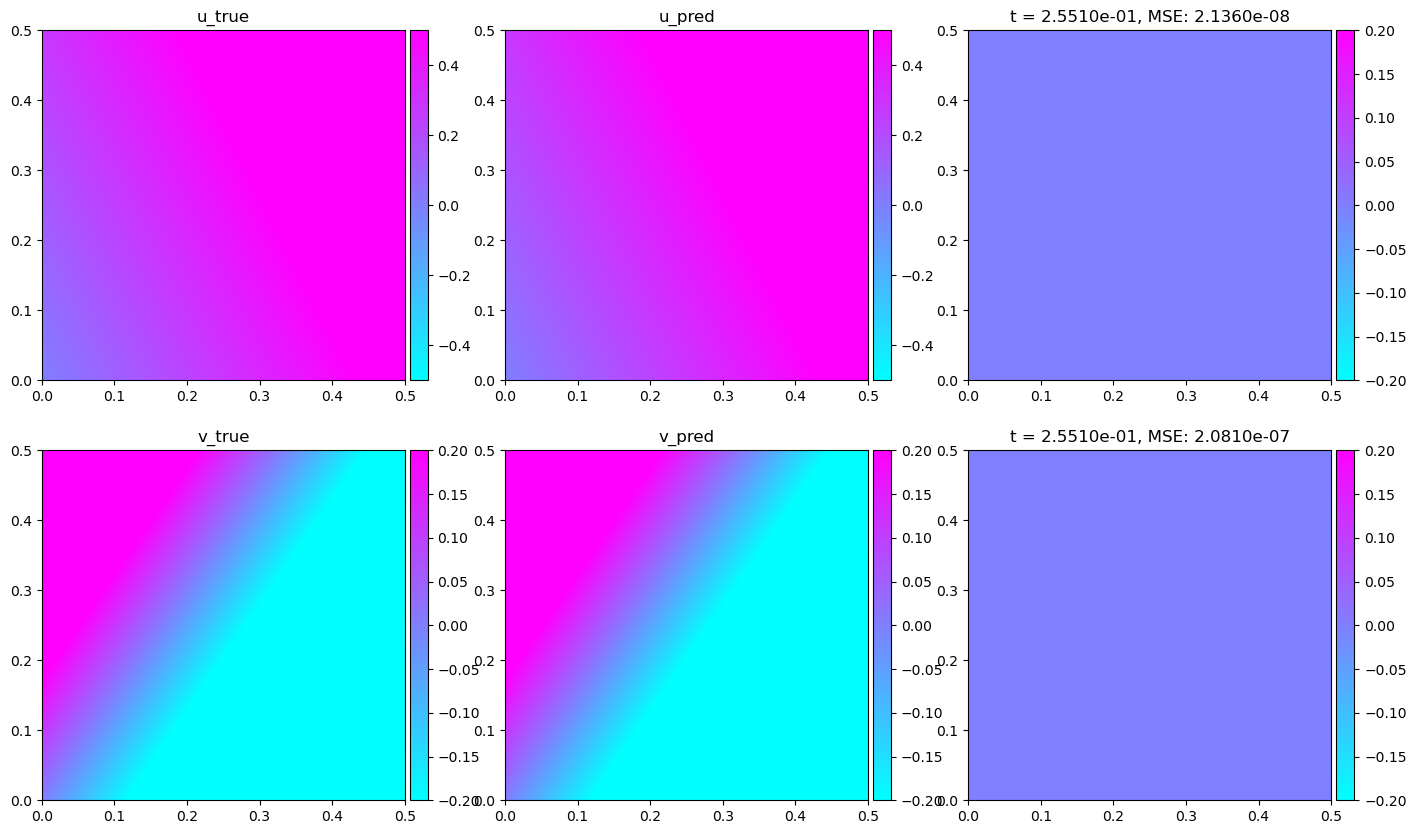

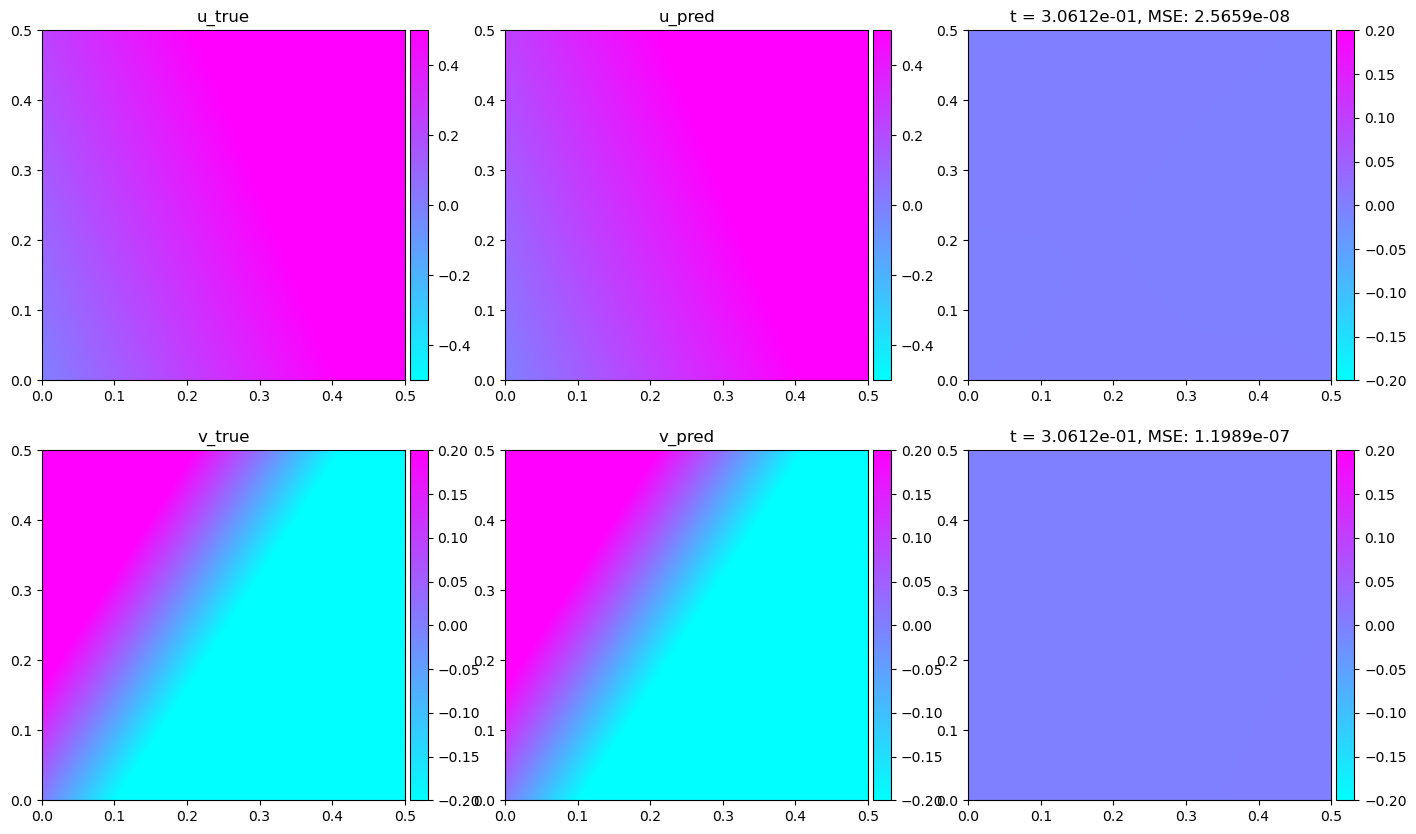

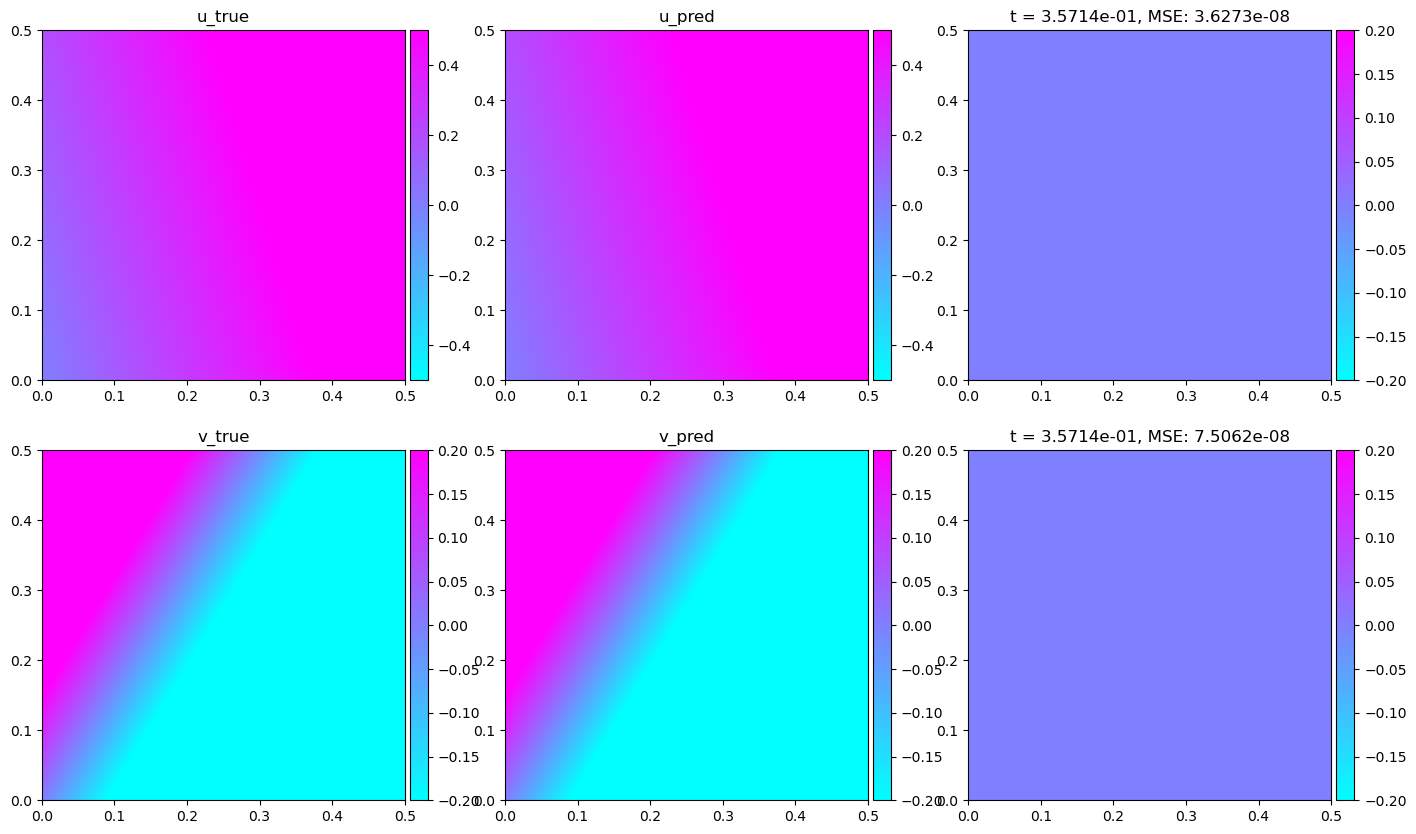

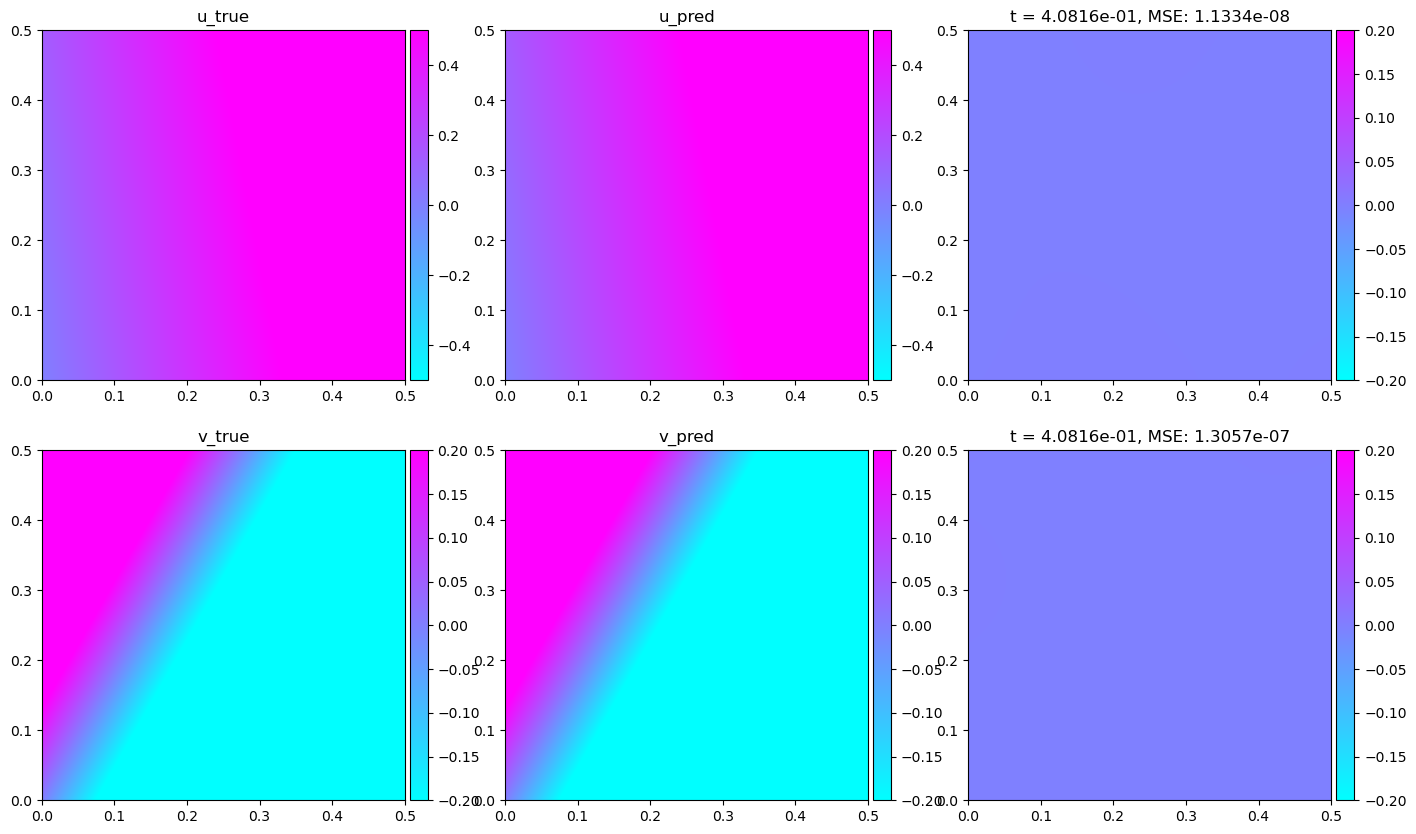

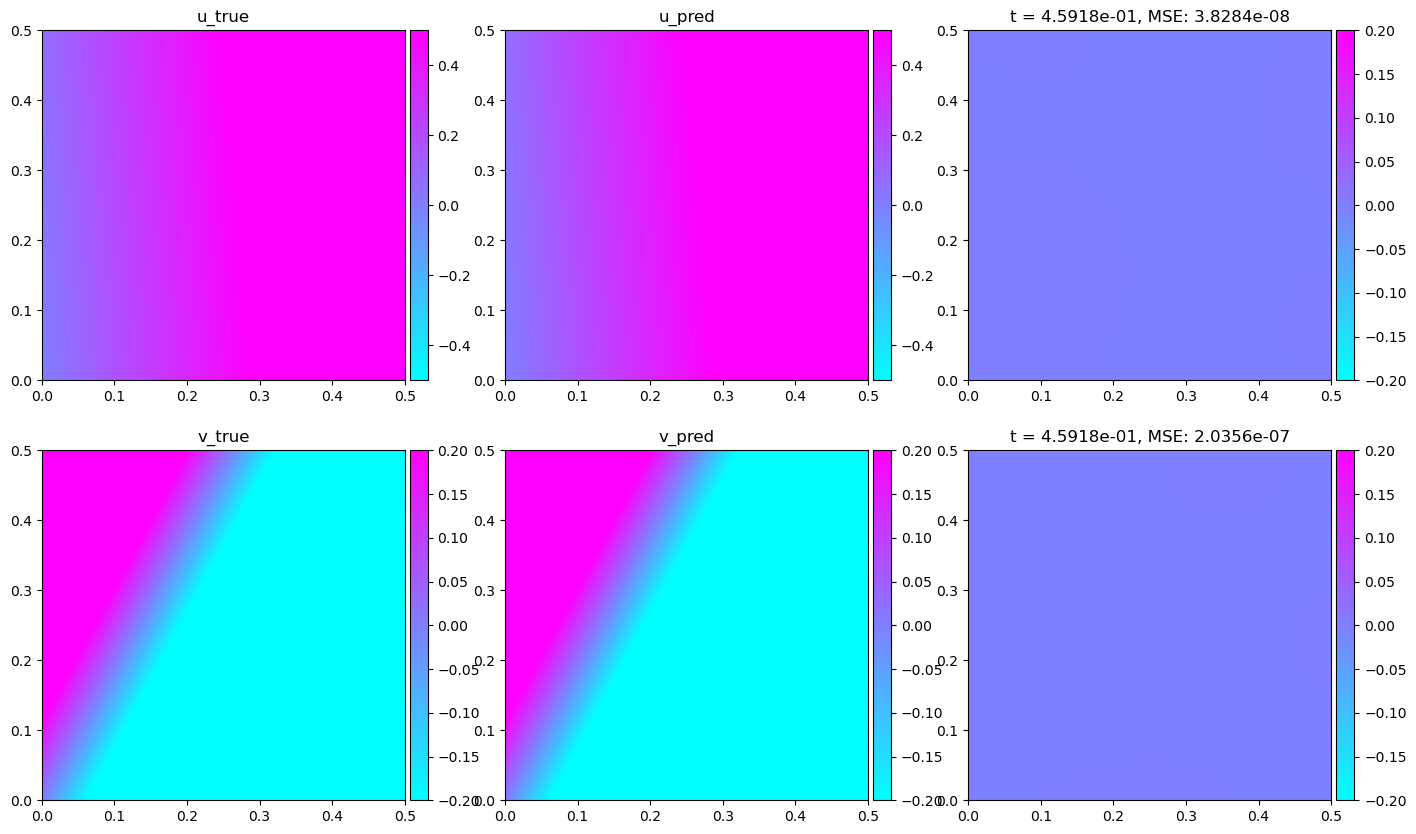

In [42]:
for i in range(0, 98, 10):
	plot_(i)

In [ ]:
# 2020/07/29, 16:58:35, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01
# 2020/07/29, 16:59:07, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01
# 2020/07/29, 16:59:42, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01
# 2020/07/29, 17:00:56, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01